#Imports

In [ ]:
# activate R magic
%load_ext rpy2.ipython

In [ ]:
%%R
# Install and load necessary packages
#install.packages("zoo")
#install.packages("xts")
#install.packages("rugarch")

#Loading pre-installed libraries
library(tidyverse)
library(zoo)
library(xts)
library(rugarch)

#Load Training Data

In [ ]:
%%R
# Read CSV file
trainBitcoin <- read.csv("/content/drive/MyDrive/CIVE7100/trainBitcoin.csv")

# Convert timestamp column to Date or POSIXct
# If your timestamp is in the "timestamp" column, adjust accordingly
alltime <- "00:00:00"
trainBitcoin$timestamp <- as.POSIXct(paste(trainBitcoin$X, alltime), format = "%Y-%m-%d %H:%M:%S", tz = "UTC")

# Create a time series object (assuming a single numeric column named "value")
trainBitcoin <- xts(trainBitcoin, order.by = trainBitcoin$timestamp)

trainBitcoin <- trainBitcoin[,-c(1, 6)]

# Print the first few rows of the time series data
print(head(trainBitcoin))

           google_trends   difficulty active_addresses     logReturn
2014-04-10        13.854 6.119726e+09           182996 -9.226568e-02
2014-04-11        12.997 6.119726e+09           169622 -1.078884e-02
2014-04-12         9.229 6.119726e+09           132283  5.306819e-02
2014-04-13        10.385 6.119726e+09           172708 -2.243118e-02
2014-04-14        10.754 6.119726e+09           183291  6.970309e-02
2014-04-15        11.053 6.119726e+09           199054  8.954052e-02


#Load Testing Data

In [ ]:
%%R
# Read CSV file
testBitcoin <- read.csv("/content/drive/MyDrive/CIVE7100/testBitcoin.csv")

# Convert timestamp column to Date or POSIXct
# If your timestamp is in the "timestamp" column, adjust accordingly
alltime <- "00:00:00"
testBitcoin$timestamp <- as.POSIXct(paste(testBitcoin$X, alltime), format = "%Y-%m-%d %H:%M:%S", tz = "UTC")

# Create a time series object (assuming a single numeric column named "value")
testBitcoin <- xts(testBitcoin, order.by = testBitcoin$timestamp)

testBitcoin <- testBitcoin[,-c(1, 6)]

# Print the first few rows of the time series data
print(testBitcoin)

           google_trends   difficulty active_addresses    logReturn
2021-07-13        88.356 1.436303e+13           690550 -0.025423570
2021-07-14        90.511 1.436303e+13           711381 -0.011202370
2021-07-15        92.666 1.436303e+13           714198 -0.011765206
2021-07-16        90.511 1.436303e+13           661189 -0.011243639
2021-07-17        90.511 1.434854e+13           548038 -0.006128980
2021-07-18        90.511 1.367259e+13           535632  0.006538345
2021-07-19        90.511 1.367259e+13           651492 -0.037530866


#Univariate ARMA GARCH


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001216    0.000551  2.20815 0.027234
ar1     0.036516    0.071632  0.50978 0.610208
ma1     0.282521    0.068639  4.11607 0.000039
omega   0.000032    0.000005  6.27956 0.000000
alpha1  0.227515    0.022187 10.25457 0.000000
beta1   0.765962    0.019008 40.29711 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001216    0.000575  2.11417 0.034500
ar1     0.036516    0.067495  0.54102 0.588492
ma1     0.282521    0.065812  4.29286 0.000018
omega   0.000032    0.000012  2.69895 0.006956
alpha1  0.227515    0.034595  6.57646 0.000000
beta1   0.765962    0.031542 24.28376 0.000000

LogLike

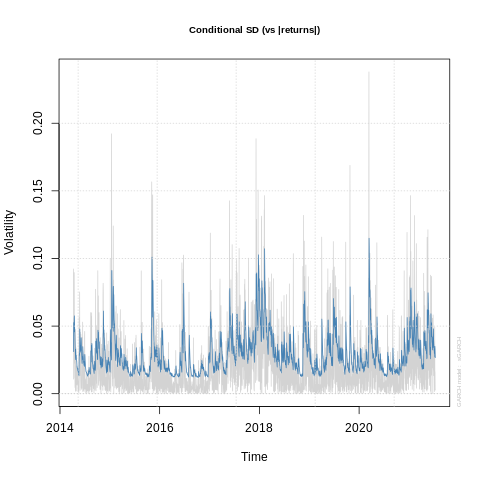

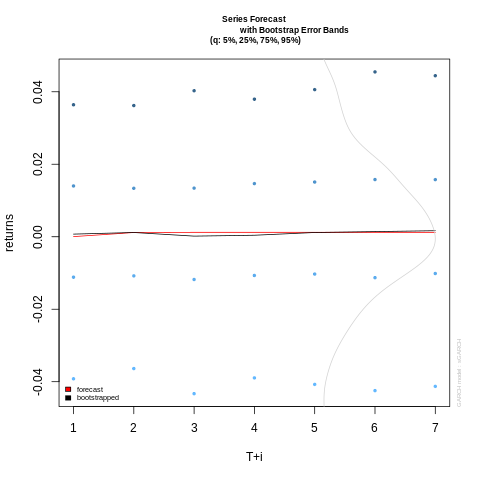

In [ ]:
%%R

spec <- ugarchspec(variance.model = list(model = "sGARCH",
                                         garchOrder = c(1, 1)),
                   mean.model = list(armaOrder = c(1, 1),
                                     distribution.model = "norm")
                   )

#print(spec)

garchfit <- ugarchfit(spec = spec, data = trainBitcoin$logReturn)
print(garchfit)

plot(garchfit, which = 3)

dfbootp = ugarchboot(garchfit,
                     method=c("Partial","Full")[1],
                     n.ahead = 7,
                     n.bootpred=1000,
                     n.bootfit=1000)
#print(dfbootp)

plot(dfbootp, which=2)

predicted <- as.vector(as.numeric(dfbootp@forc@forecast$seriesFor))
target <- as.vector(as.numeric(testBitcoin$logReturn))

garchRMSE <- sqrt(mean((target - predicted)^2))

print(garchRMSE)

#Multivariate ARMA GARCH


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.006614    0.000591 -11.19504 0.000000
ar1    -0.039816    0.085074  -0.46801 0.639776
ma1     0.285644    0.083968   3.40183 0.000669
mxreg1 -0.000046    0.000009  -4.88616 0.000001
mxreg2  0.000000    0.000000   0.00000 1.000000
mxreg3  0.000000    0.000000   0.34333 0.731353
omega   0.000001    0.000001   1.10211 0.270416
alpha1  0.050000    0.005862   8.52892 0.000000
beta1   0.900000    0.013852  64.97057 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.006614    0.021854 -0.302636 0.762167
ar1    -0.039816    0.226845 -0.175519 0.860672
ma1     0.285644    0.472616  0.604389 0.5

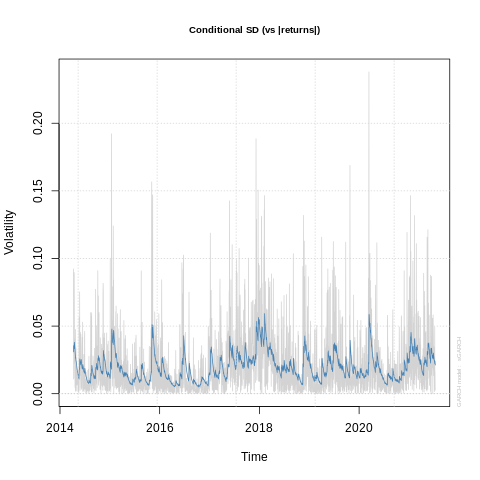

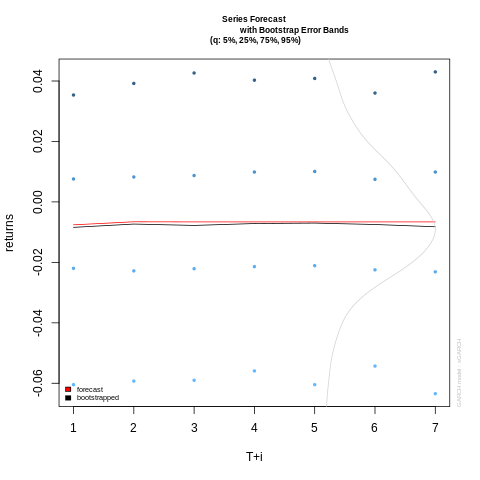

In [ ]:
%%R

bitcoinRegressors = matrix(as.numeric(trainBitcoin[,1:3]), ncol = 3)

spec <- ugarchspec(variance.model = list(model = "sGARCH",
                                         garchOrder = c(1, 1)),
                   mean.model = list(armaOrder = c(1, 1),
                                     external.regressors = bitcoinRegressors,
                                     distribution.model = "norm")
                   )

#print(spec)

garchfit <- ugarchfit(spec = spec, data = trainBitcoin$logReturn)
print(garchfit)

plot(garchfit, which = 3)

dfbootp = ugarchboot(garchfit,
                     method=c("Partial","Full")[1],
                     n.ahead = 7,
                     n.bootpred=1000,
                     n.bootfit=1000)
#print(dfbootp)

plot(dfbootp, which=2)

predicted <- as.vector(as.numeric(dfbootp@forc@forecast$seriesFor))
target <- as.vector(as.numeric(testBitcoin$logReturn))

garchRMSE <- sqrt(mean((target - predicted)^2))

print(garchRMSE)

In [ ]:
residuals(garchfit)